In [30]:
from src.gen.generator import EncoderDecoderV3
import torch
import matplotlib.pyplot as plt
import pandas as pd
from gru_pca import encode, transform, read_data
from sklearn.decomposition import PCA
from src.utils.finger import smiles2sparse
from sklearn.manifold import TSNE

model_path = ('models/GRUv3_mamut/epoch_200.pt')
model_name = model_path.split('/')[1]
epoch = model_path.split('_')[-1].split('.')[0]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

model = EncoderDecoderV3(fp_size=4860, 
                         encoding_size=32, 
                         hidden_size=512, 
                         num_layers=2, 
                         output_size=42, 
                         dropout=0,
                         teacher_ratio = 0.0,
                         fc1_size=2048,
                         fc2_size=2048,
                         fc3_size=1024,
                         random_seed=42).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))

Using device: cuda


<All keys matched successfully>

In [26]:
import rdkit.Chem as Chem
from src.utils.vectorizer import SELFIESVectorizer
vectorizer = SELFIESVectorizer()

smiles = [
    'CN(C)CCCN1C2=CC=CC=C2SC3=CC=CC=C31',  # promazine
    'CN(C)CCCN1c2ccccc2Sc2ccc(Cl)cc21',  # chlorpromazine
    'CN(C)CCCN1c2ccccc2Sc2ccc(cc12)C(F)(F)F',  # triflupromazine
    'CN1CCN(CC1)CCCN2C3=CC=CC=C3SC4=CC=CC=C42',  # perazine
    'CC1=CC2=C(NC3=CC=CC=C3N=C2S1)N4CCN(CC4)C',  # olanzapine
    'CN1CCN(CC1)C2=C3C=CC=CC3=NC4=C(N2)C=C(C=C4)Cl',  # clozapine
    'FC1=CC=C(C=C1)C(=O)CCCN1CCC(=CC1)N1C(=O)NC2=CC=CC=C12',  # droperidol
    'OC1(CCN(CCCC(=O)C2=CC=C(F)C=C2)CC1)C1=CC=C(Cl)C=C1',  # haloperidol
    'OCCOCCN1CCN(CC1)C1=NC2=CC=CC=C2SC2=CC=CC=C12'  # quetiapine
]

molecule_names = [
    'promazine',
    'chlorpromazine',
    'triflupromazine',
    'perazine',
    'olanzapine',
    'clozapine',
    'droperidol',
    'haloperidol',
    'quetiapine'
]

fps = [torch.Tensor(smiles2sparse(smile)) for smile in smiles]
fps = [fp.unsqueeze(0).to(device) for fp in fps]
fps_tensor = torch.cat(fps, dim=0)
fp_encoded, _ = model.encoder(fps_tensor)

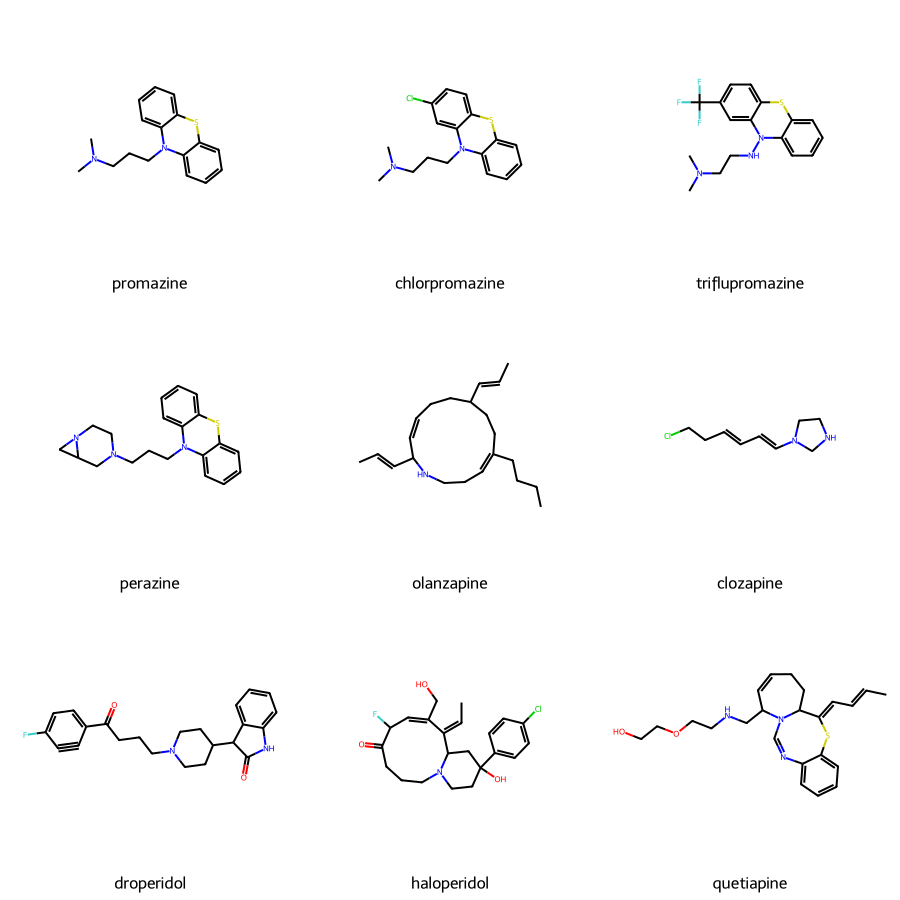

In [27]:
import selfies as sf

preds, _ = model(fp_encoded, None, omit_encoder=True)
preds = preds.detach().cpu().numpy()
preds = [vectorizer.devectorize(pred, remove_special=True) for pred in preds]
preds = [sf.decoder(x) for x in preds]
preds = [Chem.MolFromSmiles(pred) for pred in preds]
Chem.Draw.MolsToGridImage(preds, molsPerRow=3, subImgSize=(300, 300), legends=molecule_names)

In [28]:
df = pd.read_parquet('data/train_data/combined_dataset.parquet').sample(100000)
mus, _ = encode(df, model, device)

100%|██████████| 98/98 [03:29<00:00,  2.14s/it]


In [31]:
pca = PCA(n_components=2, random_state=42)
pca.fit(mus)
all_results = transform(mus, pca)
d2_encoded = encode(read_data('data/activity_data/d2_klek_100nM.parquet'), model, device)
d2_results = transform(d2_encoded[0], pca)

out = transform(fp_encoded.detach().cpu().numpy(), pca).T
out = [(x, y, name) for (x, y), name in zip(out, molecule_names)]

100%|██████████| 1/1 [00:02<00:00,  2.44s/it]


In [40]:
tsne = TSNE(n_components=2, random_state=42)
d2_encoded = encode(read_data('data/activity_data/d2_klek_100nM.parquet'), model, device)
d2_results = tsne.fit_transform(d2_encoded[0])

100%|██████████| 1/1 [00:02<00:00,  2.32s/it]


In [44]:
d2_results = d2_results.T

<Figure size 640x480 with 0 Axes>

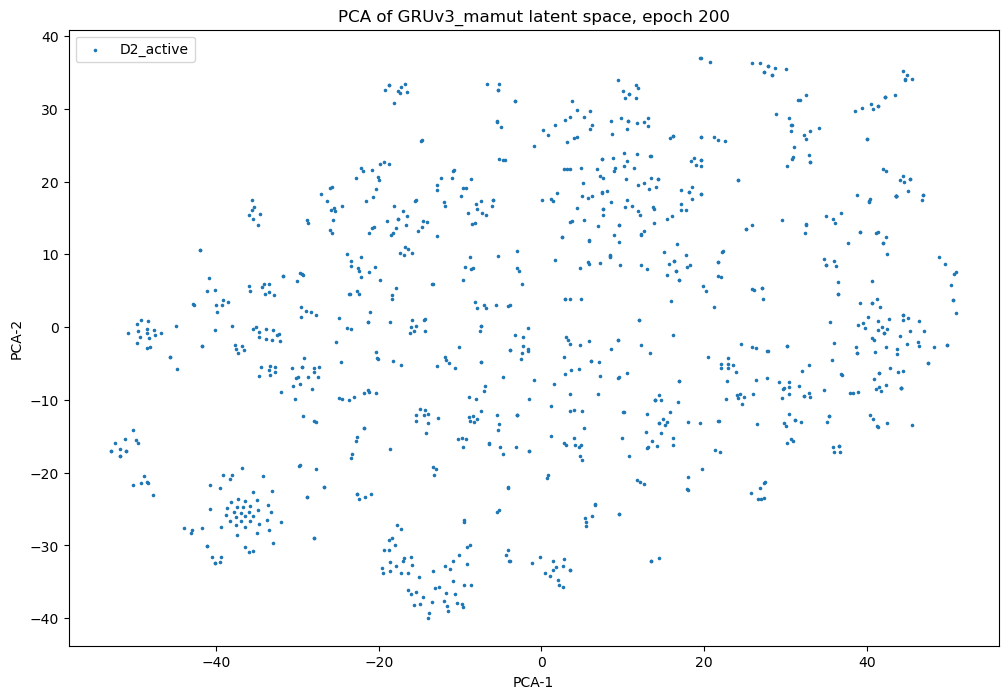

In [46]:
marker_size = 10

plt.clf()
fig = plt.figure(figsize=(12, 8))
plt.scatter(*d2_results, marker='.', label='D2_active', s=marker_size)
plt.xlabel('PCA-1')
plt.ylabel('PCA-2')
plt.legend(loc='upper left')
plt.title(f'''PCA of {model_name} latent space, epoch {epoch}''')
plt.savefig(f'PCAs/{model_name}_epoch_{epoch}.png')
plt.show()

In [14]:
from src.generator.dataset import GRUDataset
from src.utils.vectorizer import SELFIESVectorizer
from src.utils.finger import smiles2dense
import pandas as pd

smiles = [
    'CN(C)CCCN1c2ccccc2Sc2ccc(Cl)cc21', # chlorpromazine
    'CN(C)CCCN1c2ccccc2Sc2ccc(cc12)C(F)(F)F', # triflupromazine
    'FC(F)(F)c2cc1N(c3c(Sc1cc2)cccc3)CCCN4CCN(CCO)CC4', # fluphenazine
    'CN1CCN(CC1)CCCN2C3=CC=CC=C3SC4=CC=CC=C42', # perazine
    'CN1CCN(CC1)CCCN2C3=CC=CC=C3SC4=C2C=C(C=C4)C(F)(F)F' # trifluperazine
]

fps = [str(smiles2dense(x)) for x in smiles]
df = pd.DataFrame({'smiles': smiles, 'fps': fps})
vectorizer = SELFIESVectorizer(pad_to_len=128)
dataset = GRUDataset(df, vectorizer=vectorizer, fp_len=4860, smiles_enum=True)

[C]
[N]
[Branch1]
[Ring2]
[C]
[C]
[O]
[C]
[C]
[N]
[Branch2]
[Ring2]
[Branch1]
[C]
[C]
[C]
[N]
[C]
[=C]
[Branch1]
[#Branch1]
[C]
[=C]
[C]
[=C]
[Ring1]
[=Branch1]
[S]
[C]
[=C]
[C]
[=C]
[Branch1]
[=Branch2]
[C]
[Branch1]
[C]
[F]
[Branch1]
[C]
[F]
[F]
[C]
[=C]
[Ring1]
[#Branch2]
[Ring2]
[Ring1]
[C]
[C]
[Ring2]
[Ring1]
[=C]


(tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 tensor([[0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.]]))